# Goal 

The goal of this blog post is to explore some linear algebra methods for unsupervised learning

# **Image Compression with SVD**

In this part of the blog post, we explore Single Value Decomposition for image compression. 

A SVD of a real matrix $A \in \mathbb{R}^{m \times n }$ is 
\begin{equation}
    A = UDV^T , 
\end{equation}
where $D \in \mathbb{R}^{m \times n }$ only has non-zero entries in its diagonal. This non-zero values are the singular values $\sigma_i$. The other matrices $U \in \mathbb{R}^{m \times m}$ and $V \in \mathbb{R}^{n \times n }$ are orthogonal matrices. One of the reasons SVD is useful is that we can approximate some matrix $A$ using a much smaller representation. To do this, we can pick only: 
- The first $k$ columns of $U$.
- The top $k$ singular values of $D$. 
- The first $k$ rows of $V$. 

This is exactly what we will be attempting in this blog post. For this, we exctract an image from the internet and to simplify things, let us convert it to grey scale: 

[Text(0.5, 1.0, 'greyscale')]

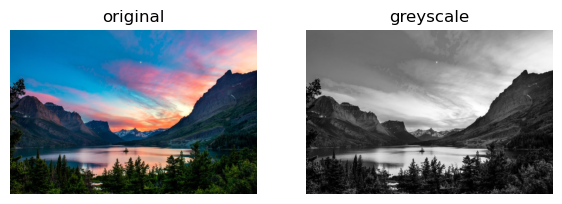

In [167]:
import PIL
import urllib
import numpy as np 
import matplotlib.pyplot as plt 

def read_image(url):
    return np.array(PIL.Image.open(urllib.request.urlopen(url)))

def to_greyscale(im):
    return 1 - np.dot(im[...,:3], [0.2989, 0.5870, 0.1140])

url = "https://cdn.shopify.com/s/files/1/0163/6622/articles/Landscape_Photo_Tips_1024x.jpg?v=1660006689"
img = read_image(url)


fig, axarr = plt.subplots(1, 2, figsize = (7, 3))
grey_img = to_greyscale(img)

axarr[0].imshow(img)
axarr[0].axis("off")
axarr[0].set(title = "original")

axarr[1].imshow(grey_img, cmap = "Greys")
axarr[1].axis("off")
axarr[1].set(title = "greyscale")


We can now write a method that finds the SVD decomposition of the image allow us to approximate it using $k$ singular values. We use a a method from numpy `linalg.svd` to do this for us. 

In [168]:
def svd_reconstruct(img, k):
    # compute the singular value decomposition (SVD) 
    U, sigma, V = np.linalg.svd(img)

    # create the D matrix in the SVD 
    D = np.zeros_like(img, dtype=float)
    D[:min(img.shape), :min(img.shape)] = np.diag(sigma)

    # Approximate img using SVD 
    U_ = U[:, :k]
    D_ = D[:k, :k]
    V_ = V[:k, :]
    A_ = U_ @ D_ @ V_ 
    return A_ 

Let us now write an experiment to see how well the approximation is as $k$ increases. Also, note that in an $m\times n$ grey scale image, we need $mn$ pixels to represent it. However, in SVD, we now that $U\in \mathbb{R}^{m\times k}$, $D\in \mathbb{R}^{k\times k}$, and $U\in \mathbb{R}^{k\times n}$, so that we only need $mk + kk + nk$ pixels to represent the image. 

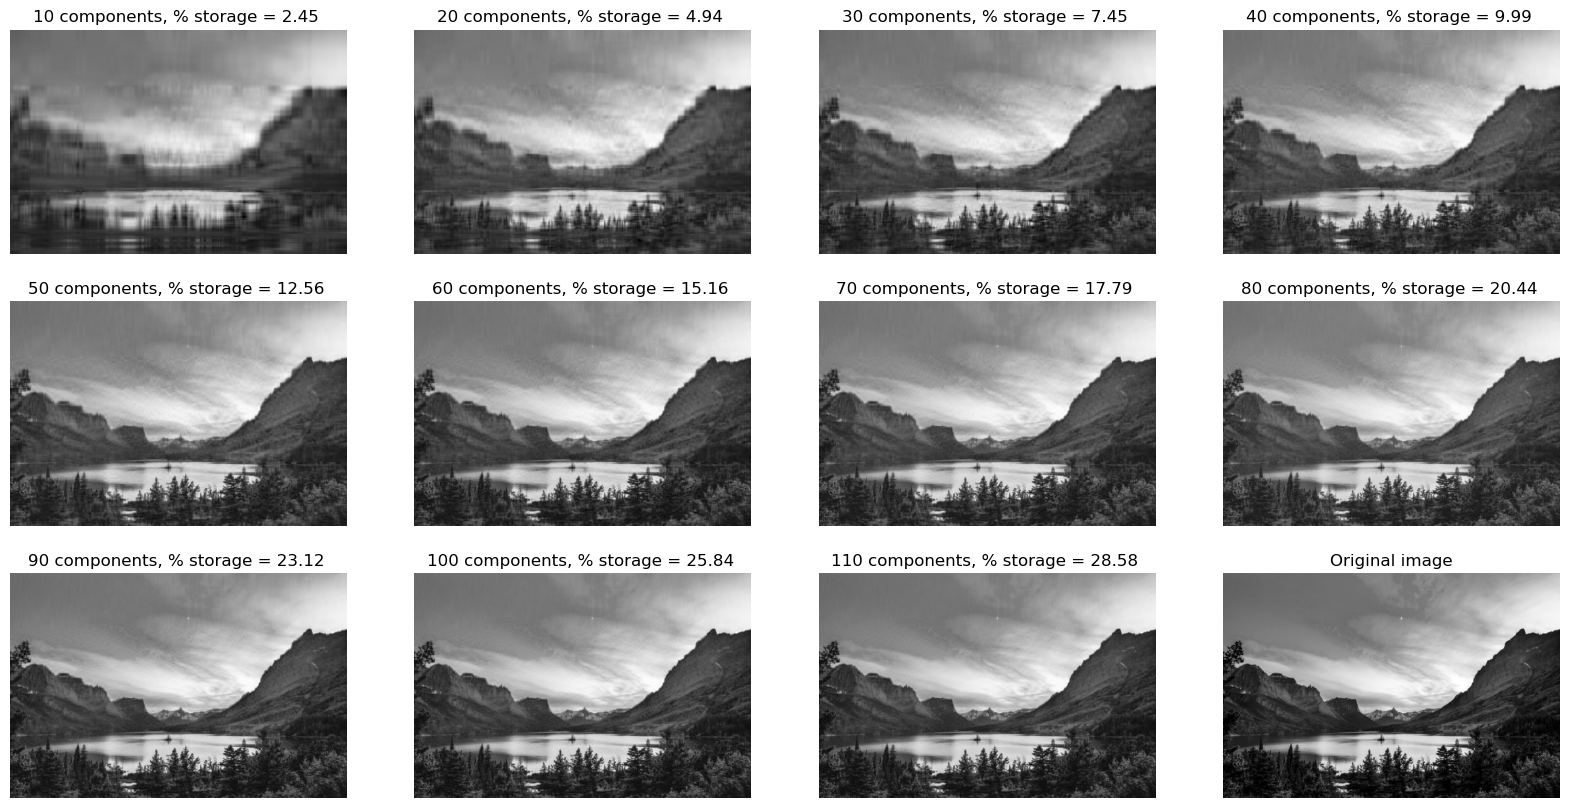

In [169]:
def svd_experiment(img, rows=3, cols= 4, increment = 10):
    fig ,axarr = plt.subplots(rows, cols, figsize=(20,10))
    for i, ax in enumerate(axarr.flatten()): 
        components  = increment + increment*i
        img_ = svd_reconstruct(img, components)
        ax.imshow(img_, cmap='Greys')
        ax.axis('off')

        # Compute the storage 
        original_storage = img.shape[0] * img.shape[1]
        new_storage = img.shape[0]*components + components**2 + components*img.shape[1]

        ax.set(title = f"{components} components, % storage = {round(new_storage/original_storage * 100, 2)} ")

        # Show the original image at the end to compare results 
        if i == rows*cols - 1: 
            ax.imshow(grey_img, cmap='Greys')
            ax.axis('off')
            ax.set(title = "Original image")

svd_experiment(grey_img)

We can see that already at around 40-50 components we already have a pretty good approximation of the image and we are only using around 12% of the original storage, remarkable! 

We can add an extra parameter to our `svd_reconstruct` function so that we can reconstruct an image to a desired compression factor instead of a $k$. To do this, suppose we have a compression factor of $\alpha$. Then we solve for $k$ in the following equation: 

$$mk + k^2 + nk = \frac{\alpha mn}{100}$$

This is simply a quadratic equation. One of its roots is negative so in the function below we just take the positive sign for the square root. Once we solve for $k$ we simply take its floor function since it must be an integer.

[Text(0.5, 1.0, 'image compressed by 20%')]

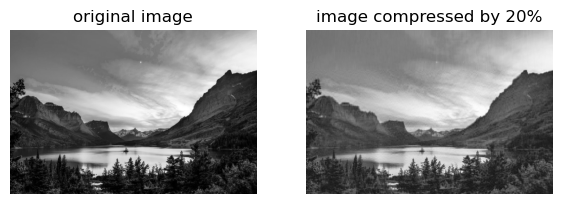

In [170]:
from math import sqrt, floor
def svd_reconstruct(img, factor):
    # compute the singular value decomposition (SVD) 
    U, sigma, V = np.linalg.svd(img)

    # create the D matrix in the SVD 
    D = np.zeros_like(img, dtype=float)
    D[:min(img.shape), :min(img.shape)] = np.diag(sigma)
    
    m, n = img.shape
    k = (-(m+n)+sqrt((m+n)**2 + (4*factor*m*n) / (100) )) / 2
    k = floor(k)
    # Approximate img using SVD 
    U_ = U[:, :k]
    D_ = D[:k, :k]
    V_ = V[:k, :]
    A_ = U_ @ D_ @ V_ 
    return A_ 

factor = 20
fig, axarr = plt.subplots(1, 2, figsize = (7, 3))
img_ = svd_reconstruct(grey_img, factor)

axarr[0].imshow(grey_img, cmap = "Greys")
axarr[0].axis("off")
axarr[0].set(title = "original image")

axarr[1].imshow(img_, cmap = "Greys")
axarr[1].axis("off")
axarr[1].set(title = f"image compressed by {factor}%")